In [1]:
import numpy as np
import matplotlib.pyplot as plt

from doepy import ProblemInstance
from doepy.models import Model, GPModel, CandidateWrapper
from doepy.training import find_active_dims
from doepy.optimize import slsqp
from doepy.constraints import ControlDeltaConstraint, MeanStateConstraint
from doepy.design_criteria import JR, NullCriterion
from doepy.noise_divergence import KL_P0Pw, KL_PwP0
from doepy.case_studies.discrete_time import nonlinear1

In [2]:
"""
Initialise models
"""
datagenmodel, Ms = nonlinear1.get()

datagen = Model(CandidateWrapper(**datagenmodel.get_candidate_dict()))
models  = []
actdims = []
fname   = 'saves/optimise_GP_models/'
for M in Ms:
    print('Training model ' + M.name)
    model = GPModel(CandidateWrapper(**M.get_candidate_dict()))
    adims = find_active_dims(M,M.x_bounds,M.u_bounds)[0]
    print('Active dims: ', adims)
    model.train(adims)
    models.append(model)

Training model M1
Training model M2
Training model M3
Training model M4


In [7]:
"""
Objective function and constraints
"""
D = Ms[0].num_inputs
N = Ms[0].num_steps

divcriterion = JR()
uconst = ControlDeltaConstraint(Ms[0].u_delta)
bounds = Ms[0].u_bounds
yconst = MeanStateConstraint(Ms[0].y_bounds)

# Create problem instance
PI = ProblemInstance(models, N, divcriterion, bounds, uconst, yconst)

# Optimize
U_initial = PI.sample_U(check_constraints=False)
optim_res = slsqp(PI, U_initial)
U_optimal = optim_res['x']

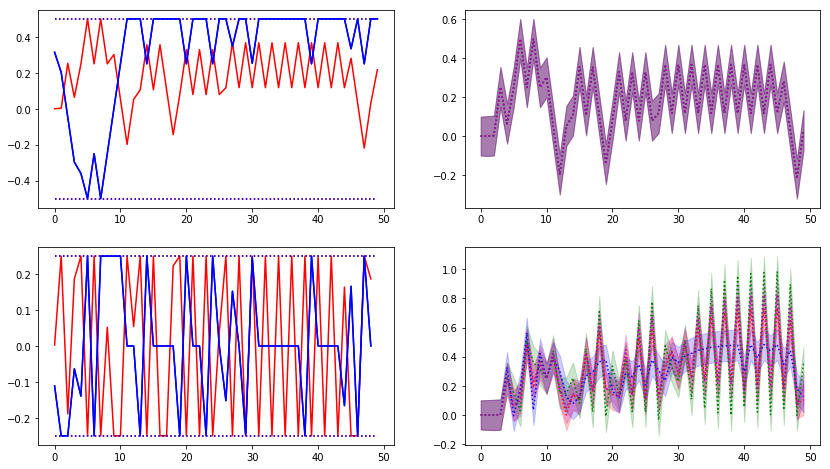

In [9]:
"""
Multi-step prediction
"""
fig, axs = plt.subplots(2,2,figsize=(14,8))

T = np.arange( U_optimal.shape[0] )

for i,ub in enumerate(Ms[0].u_bounds):
    c = ['r','b'][i]
    axs[0][0].plot(T, U_optimal[:,i], c=c)
    axs[0][0].plot(T[[0,-1]], [ub[0],ub[0]], c=c, linestyle=':')
    axs[0][0].plot(T[[0,-1]], [ub[1],ub[1]], c=c, linestyle=':')
    axs[1][0].plot(T[:-1], U_optimal[1:,i]-U_optimal[:-1,i], c=c)
    ud = Ms[0].u_delta[i]
    axs[1][0].plot(T[[0,-1]], [-ud,-ud], c=c, linestyle=':')
    axs[1][0].plot(T[[0,-1]], [ud,ud], c=c, linestyle=':')
    
axs[0][0].plot(T, U_optimal[:,1], c='b')

axs[1][0].plot(T[:-1], U_optimal[1:,1]-U_optimal[:-1,1], c='b')

def plot (p, m, s, c, l=':'):
    p.plot(T, m, c=c, linestyle=l)
    p.fill_between(T, m+2*s, m-2*s, color=c, alpha=0.2)

Yp, Ep = np.zeros((4,N,2)), np.zeros((4,N,2,2))
cols = ['r','b','g','m']
for i,model in enumerate(models):
    Xp, Sp = model.predict_x_dist( model.x0, model.S_x0, U_optimal )
    Yp[i], Ep[i] = model.predict_y_dist( Xp[:-1], Sp[:-1] )

    plot(axs[0][1], Yp[i,:,0], np.sqrt(Ep[i,:,0,0]), cols[i])
    plot(axs[1][1], Yp[i,:,1], np.sqrt(Ep[i,:,1,1]), cols[i])
plt.show()

In [13]:
"""
Experimental data
"""
_, Y = datagen.sample(datagen.x0, U_optimal, initial_uncertainty=True)

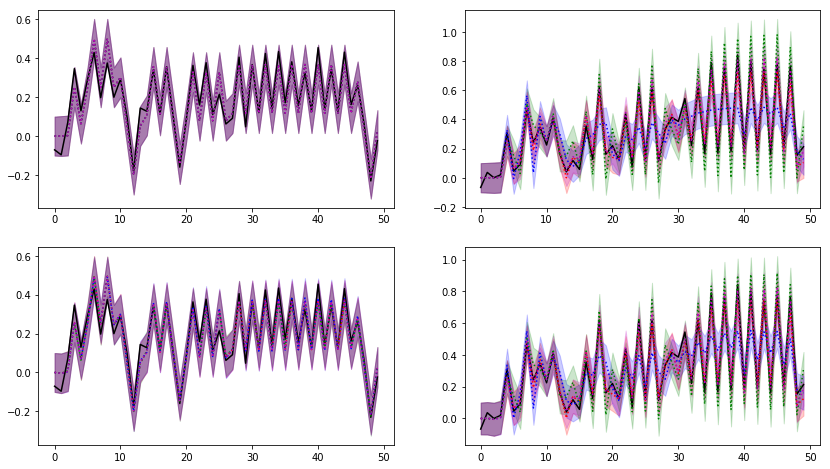

In [14]:
"""
Filtered
"""
fig, axs = plt.subplots(2,2,figsize=(14,8))
for j in [0,1]:
    axs[j][0].plot(T, Y[:,0], c='k')
    axs[j][1].plot(T, Y[:,1], c='k')

def plot (p, m, s, c, l=':'):
    p.plot(T, m, c=c, linestyle=l)
    p.fill_between(T, m+2*s, m-2*s, color=c, alpha=0.2)

Ys, Es = np.zeros((4,N,2)), np.zeros((4,N,2,2))
cols   = ['r','b','g','m']
for i,model in enumerate(models):
    plot(axs[0][0], Yp[i,:,0], np.sqrt(Ep[i,:,0,0]), cols[i])
    plot(axs[0][1], Yp[i,:,1], np.sqrt(Ep[i,:,1,1]), cols[i])

    Xk, Sk = model.predict_filter( Y, model.x0, model.S_x0, U_optimal )
    Xs, Ss = model.smooth( Xk, Sk, U_optimal )
    Ys[i], Es[i] = model.predict_y_dist( Xs, Ss )

    plot(axs[1][0], Ys[i,:,0], np.sqrt(Es[i,:,0,0]), cols[i])
    plot(axs[1][1], Ys[i,:,1], np.sqrt(Es[i,:,1,1]), cols[i])
plt.show()

In [15]:
for i,model in enumerate(models):
    errors = [ np.sum((Y-Yp[i])**2) , np.sum((Y-Ys[i])**2) ]
    print(model.name + "  {:.4f}   {:.4f}".format( *errors ))

M1  0.2973   0.2405
M2  1.8317   1.3282
M3  0.8322   0.5169
M4  0.2131   0.1899


In [16]:
"""
Noise divergences
"""
D1 = KL_P0Pw(Y, Ys, Es)
D2 = KL_PwP0(Y, Ys, Es)

print( "    ".join(["{:.3f}"]*4).format(*D1) )
print( "    ".join(["{:.3f}"]*4).format(*D2) )

0.037    0.654    0.202    0.225
0.032    2.865    0.395    0.135
